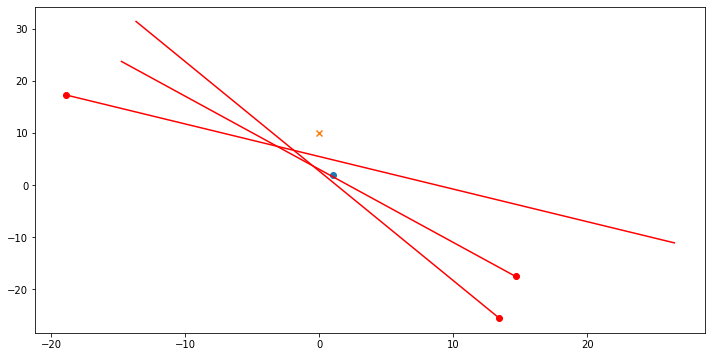

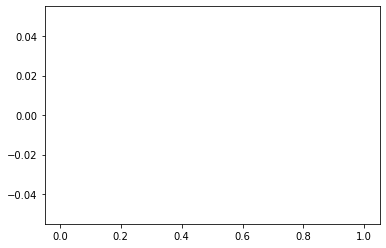

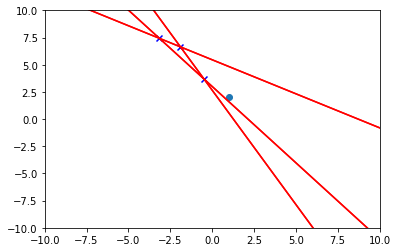

Intersections: 3
(-3.1500587333081618, 7.428805207573592)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import math

class ray:
    
    #This is defined wrt (0,0)
    def __init__(self,o,a,l,sigma_angle=0.,sigma_x=0.,sigma_y=0.):
        
        #This is the original information
        self.origin = o
        self.angle  = a
        
        #This is the ray reference point at creation (equals the origin)
        self.refPoint = self.origin
        
        
        #y-y0 = m*(x-x0), with m = tan(angle)
        #k    = -m*x0 +y0
        #Ay = Bx + C
        self.tanA = math.tan(a)
        self.m = math.tan(a)
        self.k = -self.m*self.origin[0] + self.origin[1]        
        self.length = l
        self.sigma_angle = sigma_angle
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        
        self.d0 = self.getD0fromPoint(self.origin) #this should be always 0.0
        self.d0err = self.getInitialD0Error() #initial error coming from the uncertainty of the origin+angle
        #2x2 diagonal matrix
        self.covariance = np.array([[self.d0err*self.d0err,0.0],[0.0,self.sigma_angle*self.sigma_angle]])
        
        self.end = [self.origin[0] + math.cos(self.angle)*self.length, self.origin[1] + math.sin(self.angle)*self.length]
        self.plotOrigin = [self.origin[0], self.end[0]]
        self.plotEnd    = [self.origin[1], self.end[1]]
        
    def printTrack(self):
        print("Track Properties:")
        print("d0=",self.d0," phi0=",self.angle)
        print(self.covariance)
        
    #I'm not fully sure this is correct, but should give a conservative error for d0
    #There should be a correlation between the d0 and angle that doesn't appear from this formula. 
    #I need to understand if this is correct.
    
    def getInitialD0Error(self):
        sinphi = math.sin(self.angle)
        cosphi = math.cos(self.angle)
        #d0new  = (self.d0 + dx * sinphi - dy * cosphi)
        #Let's compute d0error by the error propagation.
        dd0dx2   = sinphi*sinphi
        dd0dy2   = (-cosphi)*(-cosphi)
        dd0dphi2 = (self.sigma_x*cosphi + self.sigma_y*sinphi)*(self.sigma_x*cosphi + self.sigma_y*sinphi)
        sx2 = self.sigma_x*self.sigma_x
        sy2 = self.sigma_y*self.sigma_y
        sa2 = self.sigma_angle*self.sigma_angle
        #print(sx2,sy2,sa2)
        #print(dd0dx2*sx2,dd0dy2*sy2,dd0dphi2*sa2)
        
        d0err = math.sqrt(dd0dx2*sx2 + dd0dy2*sy2 + dd0dphi2*sa2)
        return d0err
    
        
    #Signed distance, angle between [0,2pi]
    def transformToPoint(self,point):
        dx = self.refPoint[0] - point[0]
        dy = self.refPoint[1] - point[1]
        angle=self.angle
        
        #while (angle > math.pi / 2):
        #    angle-=math.pi
        #while (angle < -math.pi / 2):
        #    angle+=math.pi
        
        sinphi = math.sin(angle)
        cosphi = math.cos(angle)
        d0new  = (self.d0 + dx * sinphi - dy * cosphi)
        self.d0 = d0new
        
        #Jacobian of the transformation
        J = np.array([[1.,dx*cosphi + dy*sinphi],[0.0,1.]])
        JT = J.transpose()
        
        self.covariance = J @ (self.covariance @ JT)
        self.d0err = math.sqrt(self.covariance[0,0])
        #Change the reference point
        self.refPoint = point
        
    
    #d = |k + mx0 -y0| / sqrt(1+m2)
    #Signed distance without transforming
    def getD0fromPoint(self,point):
        #return (-1)*(self.m*point[0] - point[1] + self.k) / math.sqrt(1 + self.m*self.m)
        return (self.m*point[0] - point[1] + self.k) / math.sqrt(1 + self.m*self.m)
        
    
def generateOrigins(point,size):
    x1 = np.random.uniform(point[0],point[0]+size[0])
    y1 = np.random.uniform(point[1],point[1]+size[1])
    return [x1,y1]

def generateAngles(angle,size):
    angle = np.random.uniform(angle,angle+size)
    return angle

#y - y1 = (y2-y1) / (x2-x1) *(x-x1)
#m = (y2-y1) / (x2-x1)
#k = -(y2-y1) / (x2-x1)*(x1) + y1
#This generates some noisy data towards a particular point given an origin 
def generatePointingRay(point, origin,sigmaAngle=0.05,sigmaXY=[4,4],sigmaL=2,distr="uniform"):
    scaleFactor=2
    angle  = math.atan2((point[1] - origin[1]), (point[0] - origin[0]))
    dx = (point[0] - origin[0])
    dy = (point[1] - origin[1])
    
    length = math.sqrt(dx*dx + dy*dy)
    
    if distr=="uniform":
        rand_angle  = generateAngles(angle,sigmaAngle)
        #rand_origin = generateOrigins(origin,sigmaXY)
        rand_length = generateAngles(length,sigmaL)*scaleFactor

    return [origin,rand_angle,rand_length]

fireLocation = [1,2]
measurements = 3
#origins = [[47,22],[35,25],[-20,-30],[-33,11],[15,15],[30,26],[60,10],[102,76]]

#generate random origins pointing to the fire
origins=[]
for i in range(measurements):
    or_x = np.random.uniform(-30,30)
    or_y = np.random.uniform(-30,30)
    origin=[or_x,or_y]
    origins.append(origin)

rays = []
d0s=[]
fig, ax = plt.subplots(figsize=(12, 6))

#origins=[[-10,-10],[10,0],[-10,10]]
#angles =[math.pi / 4., math.pi, -math.pi /4.]

for i in range(len(origins)):
    s_angle =  np.random.uniform(0.05,0.2)
    pointingRay = generatePointingRay(fireLocation,origins[i],sigmaAngle=s_angle)
    
    sigma_x = 1.
    sigma_y = 2.
    rays.append(ray(pointingRay[0],pointingRay[1],pointingRay[2],sigma_x,sigma_y))
    #rays[i].printTrack()
    ax.plot(rays[i].plotOrigin,rays[i].plotEnd,color="red")
    ax.scatter(origins[i][0],origins[i][1],color="red")
    #print ("Distance from fireLocation:",rays[i].getD0fromPoint(fireLocation))
    #print (rays[i].getD0fromPoint(origins[i]))
    #print (rays[i].getD0fromPoint(rays[i].end))
    #d0s.append(rays[i].getD0fromPoint(fireLocation))
    #d0s.append(rays[i].getD0fromPoint(rays[i].end))
    
plt.scatter(fireLocation[0],fireLocation[1],marker="o")
plt.scatter(0,10,marker="x")
plt.show()


plt.hist(d0s)
plt.show()

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if abs(div) <1e-6:
       return False

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

intersections = []

for iray in range(len(rays)):
    for jray in range(len(rays)):
        if jray <= iray:
            continue
        R1 = get_intersect(rays[iray].origin,rays[iray].end,rays[jray].origin,rays[jray].end)
        intersections.append(R1)
        plt.plot(rays[iray].plotOrigin,rays[iray].plotEnd,color="red")
        plt.plot(rays[jray].plotOrigin,rays[jray].plotEnd,color="red")
        plt.scatter(R1[0],R1[1],marker="x",color="blue")
        plt.xlim([-10,10])
        plt.ylim([-10,10])
plt.scatter(fireLocation[0],fireLocation[1],marker="o")

plt.show()
print("Intersections:",len(intersections))
print(intersections[0])


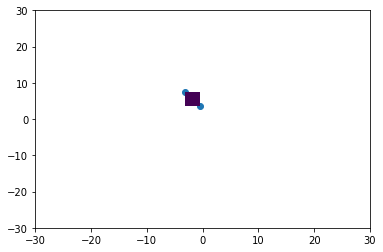

5 0 5
[-2.9280335056429276, 7.117102591751548]


In [2]:
#make a 2D histogram of the intersections
x = [intersection[0] for intersection in intersections]
y = [intersection[1] for intersection in intersections]
plt.scatter(x,y)
plt.hist2d(x, y, bins=(1000, 1000))
plt.xlim([-30,30])
plt.ylim([-30,30])
plt.show()

xmin, xmax = min(x), max(x)
ymin, ymax = min(y), max(y)
rang = [[xmin, xmax], [ymin, ymax]]
H, xedges, yedges = np.histogram2d(x, y,range=rang,bins=len(x)*2)
idx = list(H.flatten()).index(H.max())
x, y = int(idx / H.shape[1]), idx % H.shape[1]
print(idx,x,y)
seed = [(xedges[x]+xedges[x+1])/2.,(yedges[y]+yedges[y+1])/2.]
print(seed)


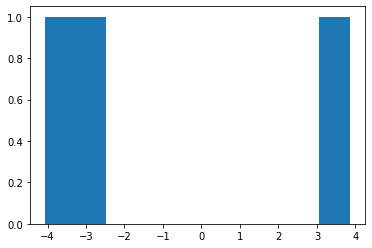

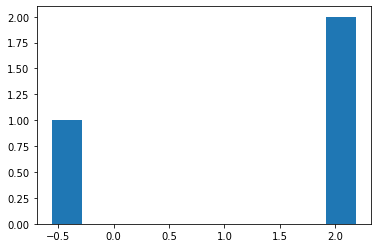

In [3]:
#Transform the rays coordinates to the seed location and check the d0s
reco_d0s   = []
reco_phi0s = []

#print(seed)
seed=[0,10]
  
for r in rays:
    r.transformToPoint(seed)
    reco_d0s.append(r.d0)
    reco_phi0s.append(r.angle)

plt.hist(reco_d0s)
plt.show()

plt.hist(reco_phi0s)
plt.show()


In [4]:
class BilloirSimple2DFitter():
    def __init__(self, tracks):
        self.tracks = tracks
        self.ntracks = len(tracks)
        self.chi2 = 0
        self.x = 0.
        self.y = 0.
        self.track_weights = []                
        
    # from NIM A311 (1992) 139-150
    # For the simple vertex, the D matrix
    # in the plane is a 1x2 matrix.
    def computeD(self,track):
        #deps / dxv
        dd0dxv = +math.sin(track.angle)
        #deps / dxv
        dd0dyv = -math.cos(track.angle)
        dd0_row = np.array([dd0dxv,dd0dyv])
        return dd0_row
    def computewi(self,track):
        Dtrk = self.computeD(track)
        #In this case Wi is the inverse of d0err2
        Wi = 1./ (track.d0err*track.d0err)
        wi = np.outer(Dtrk,Wi*Dtrk)
        return wi
    def computeTrkPerigeePos(self,track):
        xp = +track.d0 * math.sin(track.angle)
        yp = -track.d0 * math.cos(track.angle)
        return np.array([xp,yp])
    
    #This returns an tuple made of (vtxLocation, vtxErrorMatrix)
    def computeVtxLocation(self):
        Swi  = np.array([[0.0,0.0],[0.0,0.0]])
        T    = np.array([0.0,0.0])
        for itrk in range(self.ntracks):
            trk=self.tracks[itrk]
            wtrk = self.computewi(trk)
            Swi += wtrk
            xptrk = self.computeTrkPerigeePos(trk)
            T += wtrk @ xptrk
        
        A=la.inv(Swi)
        V = A @ T
        return (V,A)



lastVtx = [0,10]
errMatrix = None
iter_d0=[]
raystofit=[]
for i in range(2):
    #print("lastVtx:",lastVtx)
    for iray in range(len(rays)):
        rays[iray].transformToPoint(lastVtx)
        raystofit.append(rays[iray])
        #rays[iray].printTrack()
    
    #billVtx_iter = BilloirSimple2DFitter(raystofit,iter_d0)
    billVtx_iter = BilloirSimple2DFitter(raystofit)
    dVtx = billVtx_iter.computeVtxLocation()
    print("FitVtx:",dVtx[0])
    print("FitVtxErrorMatrix")
    print(dVtx[1])
    lastVtx += dVtx[0]
    errMatrix = dVtx[1]
    raystofit=[]

print("===>",lastVtx)
    

FitVtx: [-2.38566805 -3.09966318]
FitVtxErrorMatrix
[[ 2512.14113861 -2081.99503747]
 [-2081.99503747  2165.17249673]]
FitVtx: [ 0.00845374 -0.00758033]
FitVtxErrorMatrix
[[ 2321.76211606 -1941.6738611 ]
 [-1941.6738611   2043.26480763]]
===> [-2.37721431  6.89275649]


[[ 2321.76211606 -1941.6738611 ]
 [-1941.6738611   2043.26480763]]


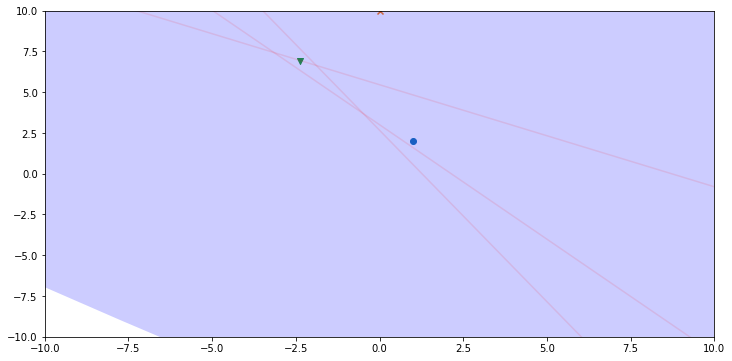

In [5]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

#Plot the vertex + ellipse.
#Method from : https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

#This takes the tuple: vertex location and covariance matrix

def plotEllipse(vtxTuple,ax,n_std=1,facecolor='blue',**kwargs):
    loc = vtxTuple[0]
    cov = vtxTuple[1]
    print(cov)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    #For us, 1 standard deviation is OK, but you can scale it if you prefer.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    
    transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(loc[0], loc[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(12, 6))

for r in rays:
    ax.plot(r.plotOrigin,r.plotEnd,color="red",alpha=0.1)
    ax.scatter(r.origin[0],r.origin[1],color="red")

plt.scatter(fireLocation[0],fireLocation[1],marker="o")
plt.scatter(0,10,marker="x")
plt.scatter(lastVtx[0],lastVtx[1],marker="v")
plotEllipse((lastVtx,errMatrix),ax,alpha=0.2)
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()
    
    



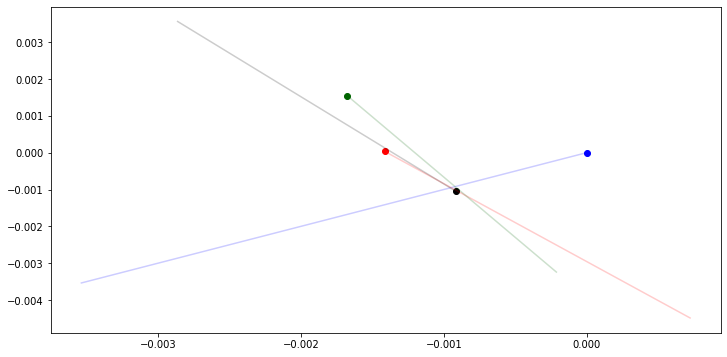

0.21967587860894142
0.06649759089801124
0.07607566362253082
0.10008093828865577
0.0020883015743007735
0.0015609779101769029
0.00012003270299675436
0.0040542486522213055
===> [-0.00095457 -0.00095537]
(lon,lat) [-122.24277403096106, 37.243821201957154]
[[ 7.72756818e-07 -1.80047683e-06]
 [-1.80047683e-06  4.28842399e-06]]


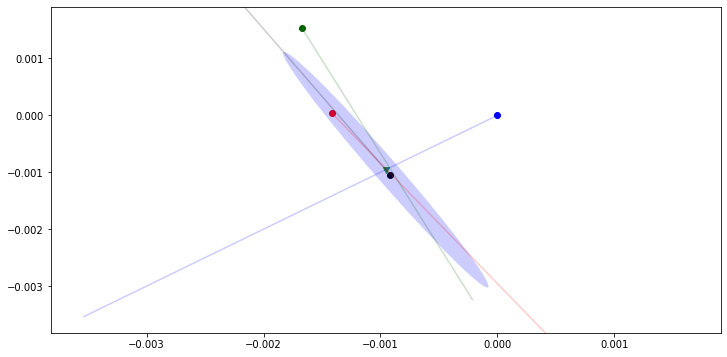

In [21]:
#This snippet should find the vertex for the test data
#lat, lon, angle, error
#37.29856, -122.17402, 225, 1.0
#37.30053, -122.27581, 154.7, 9.0
#37.23866, -122.24004, 337.1, 9.0
#37.38690, -122,29460, 163, 1.0
#The angle should be wrt the true north

#Return the angle between [0,2pi]
def degToRad(angle):
    rad_angle = (angle / 180.)*(math.pi)
    return rad_angle

def radToDeg(rad_angle):
    angle = (rad_angle / math.pi)*180.
    return angle

#flat earth approx from http://www.edwilliams.org/avform147.htm#flat
#Assumed spherical earth
#Angles in deg
def toFlat(lon0,lat0,lon,lat,R=6378.137):
    dlat=degToRad(lat)-degToRad(lat0) 
    dlon=degToRad(lon)-degToRad(lon0)
    distance_North=R*dlat
    distance_East=R*math.cos(degToRad(lat0))*dlon
    return [distance_East,distance_North]

def toSphere(lon0,lat0,distance_East,distance_North,R=6378.137):
    dlat = distance_North / R
    dlon = distance_East / (R*math.cos(degToRad(lat0)))
    lat = dlat+degToRad(lat0)
    lon = dlon+degToRad(lon0)
    return [radToDeg(lon),radToDeg(lat)]
    
def transAngle(angle):
    rad_angle = degToRad(angle)
    rad_angle = math.pi/2. - rad_angle
    return rad_angle

test_origins_lonlat = [
                    [-122.17402,37.29856],
                    [-122.27581,37.30053],
                    [-122.24004,37.23866],
                    [-122.29460,37.38690]
                    ]

test_origins = [toFlat(-122.17402,37.29856,-122.17402,37.29856,1),
                toFlat(-122.17402,37.29856,-122.27581,37.30053,1),
                toFlat(-122.17402,37.29856,-122.24004,37.23866,1),
                toFlat(-122.17402,37.29856,-122.29460,37.38690,1),
                
]

#for to in test_origins:
#    print(to)
                    
test_angles  = [[transAngle(225),transAngle(1.0)], 
                [transAngle(154.7),transAngle(9.0)], 
                [transAngle(337.1),transAngle(9.0)],
                [transAngle(163),transAngle(1.0)]]

test_rays=[]

for i in range(len(test_origins)):
    #print(test_origins[i],test_angles[i][0])
    test_rays.append(ray(test_origins[i],test_angles[i][0],0.005,test_angles[i][1]))
    
fig, ax = plt.subplots(figsize=(12, 6))
colors=["blue","red","black","darkgreen"]
for itray in range(len(test_rays)):
    ax.plot(test_rays[itray].plotOrigin,test_rays[itray].plotEnd,color=colors[itray],alpha=0.2)
    ax.scatter(test_rays[itray].origin[0],test_rays[itray].origin[1],color=colors[itray])

plt.show()


lastVtx = [0.1,0.1]
errMatrix = None
iter_d0=[]
raystofit=[]
for i in range(2):
    #print("lastVtx:",lastVtx)
    for iray in range(len(test_rays)):
        test_rays[iray].transformToPoint(lastVtx)
        raystofit.append(test_rays[iray])
        #test_rays[iray].printTrack()
        print(test_rays[iray].d0err)
    
    #billVtx_iter = BilloirSimple2DFitter(raystofit,iter_d0)
    billVtx_iter = BilloirSimple2DFitter(raystofit)
    dVtx = billVtx_iter.computeVtxLocation()
    #print("FitVtx:",dVtx[0])
    #print("FitVtxErrorMatrix")
    #print(dVtx[1])
    lastVtx += dVtx[0]
    errMatrix = dVtx[1]
    raystofit=[]

print("===>",lastVtx)
print("(lon,lat)",toSphere(-122.17402,37.29856,lastVtx[0],lastVtx[1],1))


fig, ax = plt.subplots(figsize=(12, 6))
colors=["blue","red","black","darkgreen"]
for itray in range(len(test_rays)):
    ax.plot(test_rays[itray].plotOrigin,test_rays[itray].plotEnd,color=colors[itray],alpha=0.2)
    ax.scatter(test_rays[itray].origin[0],test_rays[itray].origin[1],color=colors[itray])

plt.scatter(fireLocation[0],fireLocation[1],marker="o")
plt.scatter(0,10,marker="x")
plt.scatter(lastVtx[0],lastVtx[1],marker="v")
plotEllipse((lastVtx,errMatrix),ax,alpha=0.2)
f=3
plt.xlim([lastVtx[0]-abs(f*lastVtx[0]),lastVtx[0]+abs(f*lastVtx[0])])
plt.ylim([lastVtx[1]-abs(f*lastVtx[1]),lastVtx[1]+abs(f*lastVtx[1])])
plt.show()


